# Test mapping of cloud depth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap

## First load all the files

In [3]:
from maplib import get_wavel, cloud_depth, stringy, load_out3

In [4]:
file_root = 'static_weather_results/HATP_7b'

In [5]:
lons  = np.arange(-180., 180.01, 15) # deg
lats  = np.arange(0., 67.51, 22.5) # deg
nprof = len(lons) * len(lats) # number of (lon, lat) profiles

In [6]:
# Get the wavelengths of interest. Assume all files are the same
wavel_file = file_root + '_Phi{}Theta{}/out3_extinction.dat'.format(stringy(lons[0]), stringy(lats[0]))
wavel = get_wavel(wavel_file) # um

In [7]:
# Read in the cloud depth values for each file.
# Make a 3D array with dimensions (lon, lat, wavel)
NLO, NLA, NWA = len(lons), len(lats), len(wavel)
Z = np.zeros((NLO, NLA, NWA))
for i in range(NLO):
    for j in range(NLA):
        w, d = cloud_depth(stringy(lons[i]), stringy(lats[j]))
        Z[i,j,:] = d

# The 180 longitude is same as -180
#Z[0,:,:] = Z[-1,:,:]

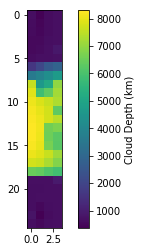

In [8]:
# rough sketch of where we are using imshow
im = Z[:,:,20]
plt.imshow(im)
plt.colorbar(label='Cloud Depth (km)')

In [9]:
np.mean(Z[:,:,30] - Z[:,:,0])

931.2627714150648

## Try out basemap

In [10]:
X, Y = np.meshgrid(lons,lats)

Text(0.5, 1.0, 'HAT-P-7b, 1.0 $\\mu$m')

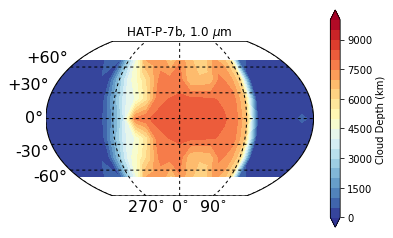

In [11]:
fig = plt.figure()
ax  = plt.subplot(111)
m = Basemap(projection='kav7',lon_0=0,resolution=None)

nlev = 21
#levels = np.linspace(np.amin(Z),np.amax(Z),nlev)
levels = np.linspace(0, 10000, nlev)

cmap = plt.cm.RdYlBu_r

iw = 10
CS = m.contourf(X,Y,Z[:,:,iw].T,levels=levels,extend='both',cmap=cmap,latlon=True)

# mirror southern-hemisphere
CS = m.contourf(X, -Y, Z[:,:,iw].T, levels=levels, extend='both', cmap=cmap, latlon=True)

def fmtfunc(inlon):
        string = r'{:g}'.format(inlon)+r'$^{\circ}$'
        #print string                                                                                                   
        return string

meridians = np.arange(0., 360., 90)
m.drawmeridians(meridians, labels=[False,False,False,True],
                    labelstyle=None, fmt=fmtfunc, dashes=[3,3], color='k', fontsize=16)
parallels = np.arange(-90., 90, 30)
m.drawparallels(parallels, labels=[True,False,False,False],
                    labelstyle='+/-', dashes=[3,3], color='k',fontsize=16)

plt.colorbar(label='Cloud Depth (km)')
plt.title('HAT-P-7b, {:.1f} $\mu$m'.format(wavel[iw]))

In [12]:
print(levels)

[    0.   500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.
  5000.  5500.  6000.  6500.  7000.  7500.  8000.  8500.  9000.  9500.
 10000.]


# Test the python script

In [13]:
import map_cloud_depth as mcd

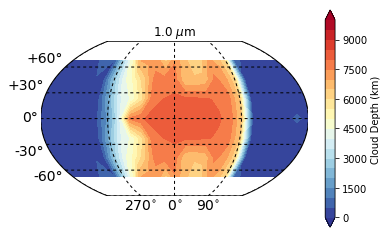

In [14]:
test = mcd.map_cloud_depth(10)

In [15]:
mcd.Z.shape

(25, 4, 31)

In [16]:
Z.shape

(25, 4, 31)

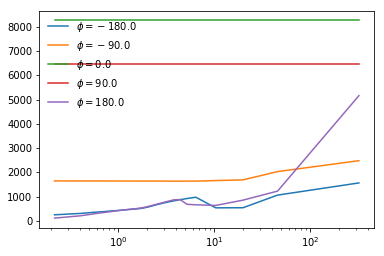

In [18]:
for i in range(len(lons))[::6]:
    plt.plot(wavel, mcd.Z[i,0,:], label='$\phi = {:.1f}$'.format(lons[i]))

plt.semilogx()
plt.legend(loc='upper left', frameon=False)

In [20]:
np.sum(mcd.Z - Z)

0.0

## Make a widget

Need to have ipywidgets installed. I recommend using

`conda install -c conda-forge ipywidgets`

In [21]:
import ipywidgets as widgets
from ipywidgets import interact

In [22]:
def widget_map(i):
    result = mcd.map_cloud_depth(i)
    return

In [23]:
w = widgets.IntSlider(10, min=0, max=len(wavel)-1, continuous_update=False)
interact(widget_map, i=w)

interactive(children=(IntSlider(value=10, continuous_update=False, description='i', max=30), Output()), _dom_c…

<function __main__.widget_map(i)>

## Look at vertical extinction profile

In [24]:
from maplib import get_ext_data

In [28]:
# A random example sight line (that has clouds)
z, dtau_dz = load_out3('extinction', lons[6], lats[0])
dust   = load_out3('dust', lons[6], lats[0])
thermo = load_out3('thermo', lons[6], lats[0])

rho_d = dust['rhod/rho'] * thermo['rho']

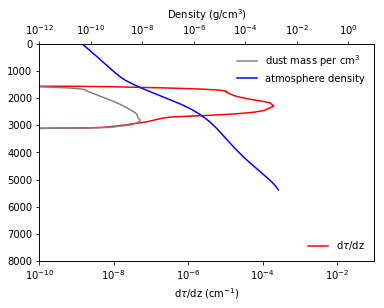

In [32]:
i = 10
ax = plt.subplot(111)
ax.plot(dtau_dz[:,i], z*1.e-5, color='r', label=r'd$\tau$/dz')
ax.set_ylim(8000, 0)
ax.set_xscale('log')
ax.set_xlim(1.e-10, 0.1)
ax.set_xlabel(r'd$\tau$/dz (cm$^{-1}$)')
plt.legend(loc='lower right', frameon=False)

ax1 = ax.twiny()
ax1.plot(rho_d, z*1.e-5, color='0.5', label='dust mass per cm$^3$')
ax1.set_xscale('log')
ax1.plot(thermo['rho'], z*1.e-5, color='b', label='atmosphere density')
ax1.set_xlim(1.e-12, 10)
ax1.set_xlabel('Density (g/cm$^3$)')

plt.legend(loc='upper right', frameon=False)